# L4 - Reinforcement learning

**Reinforcement learning** is one of the machine learning approaches, where our agent learns by interacting with the some environment. In contrast to the supervised learning there are no labeled objects. However, agent can get rewards, making some actions. The goal of the agent is to maximize the total reward over some time period. 

This lab is mainly based on the [book](http://incompleteideas.net/book/bookdraft2018jan1.pdf). You just must read it, if you are interesting in reinforcement learning.

### 1. Multi-armed bandit problem

#### Problem statement
##### Informal
Let we have $N$ slot machines. Playing on the $i$th slot, the agent receives some random reward. The agent doesn't know probability distribution of rewards, however it needs to maximize winnings after $T$ games.

##### Formal
Let $\mathcal{A}$ be a finite set of possible actions. For each action $a \in \mathcal{A}$ agent can get some reward which is determined by the unknown probability distribution $p(r|a)$. The strategy of the agent (policy) at time $t$ is some probability distribution on the set of actions – $\pi_t(a)$.

Games' steps:
> 1. Agent has some initial policy $\pi_1(a)$
> 2. At time  $1 \leq t \leq T$:
> 3. Agent randomly chooses action $a_t \sim \pi_t(a)$
> 4. Gets some reward $r_t \sim p(r|a_t)$
> 5. And update its policy $\pi_t \rightarrow \pi_{t+1}$

Let $c_t(a)$ be how many times action $a$ was used at  moment $t$
$$c_t(a) = \sum_{i=1}^{t}[A_i = a].$$
Then agent needs to minimize its regret
$$T\cdot\mu^* - \sum_a \mu_a \mathbb{E}[c_T(a)]$$
* $\mu_a$ – expected value of reward for action $a$
* $\mu^* = \max_a \mu_a$ – expected value of reward for optimal action

So we can define regrest as following
$$T\cdot\mu^* - \mathbb{E}\big[ \sum_{t=1}^{T} R_t \big].$$

The first task was formulated in this [paper](http://projecteuclid.org/download/pdf_1/euclid.bams/1183517370).
#### Model problem
1. $|A| = 100, T = 1000$
2. $\mu_a \sim \mathcal{N}(0, 1)$
3. $p(r|a) = \mathcal{N}(r; \mu_a, 1)$

The game simulated $10^4$ times and we are interesting in plot **[step]** $\times$ **[average total reward at current step]**.

1. $Q_t(a)$ – average reward of action $a$ by moment $t$ (value of action), $\lim_{c_t(a) \rightarrow \infty} Q_t(a) =\mu_a$.
2. $Q^*(a) = \lim_{t \rightarrow \infty} Q_t(a) = \mu_a$ – value of cation $a$.
3. $\mathcal{A}_t = \arg\max_a Q_t(a)$ – set of actions that has the greatest average reward at moment $t$.

#### Greedy policy
$$\pi_t(a)= \frac{1}{|\mathcal{A}_t|}[a \in \mathcal{A}_t].$$

#### Exercises
1. Implement gready policy.
2. What is main disadvantages?
3. How do you init $\pi$? Is there any better option?
4. Check this policy on model problem.

In [189]:
import numpy as np
import time
from tqdm import tqdm
from matplotlib import pyplot as plt
plt.style.use('seaborn')
%matplotlib inline

Some constants

In [2]:
BANDIT_COUNT = 100   
STEP_COUNT = 1000    # steps per game
ITER_COUNT = 100     # number of games

Create enviroment

In [112]:
np.random.seed(100500)
reward_expectations = np.random.normal(
                            loc=0, 
                            scale=1, 
                            size=BANDIT_COUNT)


def get_reward(action, reward):
    return np.random.normal(loc=reward[action], scale=1)

In [121]:
for i, mu in list(enumerate(reward_expectations))[:6]:
    print("{:>2} --> {: .3f}".format(i, mu))
    
max_reward = np.max(reward_expectations)
MAX_FINAL_REWARD = max_reward * STEP_COUNT

print("\nOptimal expected total reward is {:.3f}".format(MAX_FINAL_REWARD))

 0 --> -0.807
 1 -->  1.017
 2 --> -0.246
 3 -->  1.062
 4 -->  0.637
 5 -->  1.165

Optimal expected total reward is 2695.570


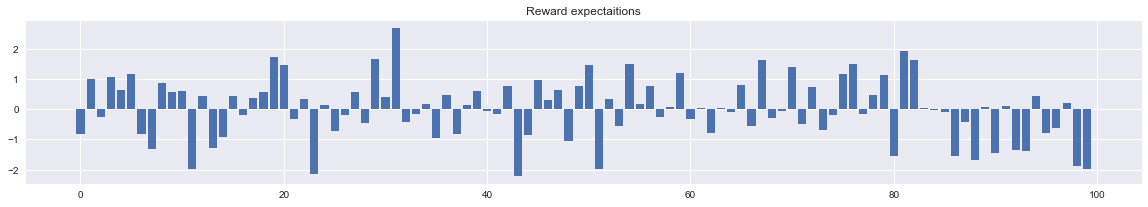

In [170]:
plt.figure(figsize=(20, 3))
plt.title('Reward expectaitions')
plt.bar(np.arange(BANDIT_COUNT), reward_expectations)
plt.show()

In [132]:
def eval_agent(agent, **params):
    reward_history_average = np.zeros(STEP_COUNT)
    reward_accumulated_average = np.zeros(STEP_COUNT)
    action_value_average = np.zeros(BANDIT_COUNT)
    
    for i in tqdm(range(ITER_COUNT)):
        hist, accum, val = agent(**params)

        reward_history_average += hist
        reward_accumulated_average += accum
        action_value_average += val
        
    reward_history_average /= ITER_COUNT
    reward_accumulated_average /= ITER_COUNT
    action_value_average /= ITER_COUNT

    return reward_history_average, reward_accumulated_average, action_value_average

### Greedy agent

In [141]:
def play_greedy(action_value):
    action_count = np.zeros(BANDIT_COUNT)   # c(a) = 0
    reward_history = np.zeros(STEP_COUNT)   # store reward at each step
    reward_accumulated = np.zeros(STEP_COUNT)

    for t in range(STEP_COUNT):
        # choose action greedy
        action = np.random.choice(np.flatnonzero(action_value == np.max(action_value)))
        reward = get_reward(action, reward_expectations)
        
        # update reward estimations
        if action_count[action]:
            action_value[action] += (reward - action_value[action]) / action_count[action]
        else:
            action_value[action] = reward
            
        # update stats
        action_count[action] += 1
        reward_history[t] = reward
        reward_accumulated[t] = reward_accumulated[t - 1] + reward
        
    return reward_history, reward_accumulated, action_value

Now let's see how greedy agent performs for different initial values

In [142]:
init_zeros = eval_agent(play_greedy, action_value=np.zeros(BANDIT_COUNT))
init_ones = eval_agent(play_greedy, action_value=np.ones(BANDIT_COUNT))
init_five = eval_agent(play_greedy, action_value=5*np.ones(BANDIT_COUNT))

100%|██████████| 100/100 [00:02<00:00, 37.76it/s]


Now lets plot average reward for each time step:

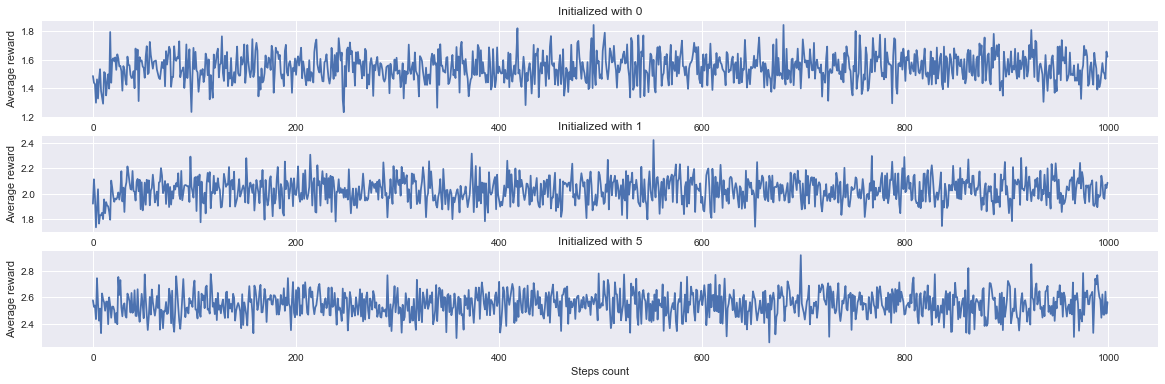

In [146]:
plt.figure(figsize=(20, 6))

plt.subplot('311')
plt.title('Initialized with 0')
plt.xlabel('Steps count')
plt.ylabel('Average reward')
plt.plot(init_zeros[0])

plt.subplot('312')
plt.title('Initialized with 1')
plt.xlabel('Steps count')
plt.ylabel('Average reward')
plt.plot(init_ones[0])

plt.subplot('313')
plt.title('Initialized with 5')
plt.xlabel('Steps count')
plt.ylabel('Average reward')
plt.plot(init_five[0])

plt.show()

As we can see this plots are not wery informative because there are alot of noize. Thats not surprising because at first we make random steps, which affect our next moves.

Now let's see graphs of the accumulated reward for each initialization

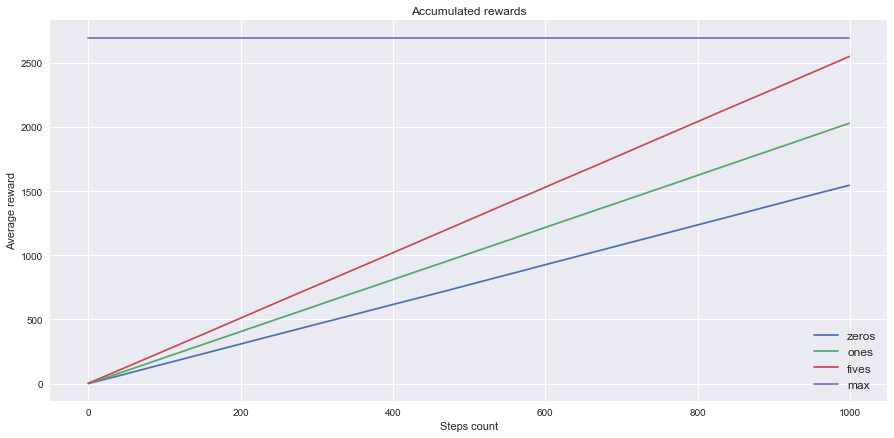

In [176]:
plt.figure(figsize=(15, 7))

plt.title('Accumulated rewards')
plt.xlabel('Steps count')
plt.ylabel('Average reward')

plt.plot(init_zeros[1], label='zeros')
plt.plot(init_ones[1], label='ones')
plt.plot(init_five[1], label='fives')
plt.plot([MAX_FINAL_REWARD] * STEP_COUNT, label='max')

plt.legend(fontsize='large')
plt.show()

As we can see greedy policy with initial parameters set to $0$ does not yield very good results. The reason might be that agent only exploits the enviroment. After we increase initial reward estimations the accumulated reward increases dramatically and almost reaches `MAX_FINAL_REWARD`. This happens because when initial values are higher then average rewards our agent explores the enviroment first and eventually it chooses better strategy

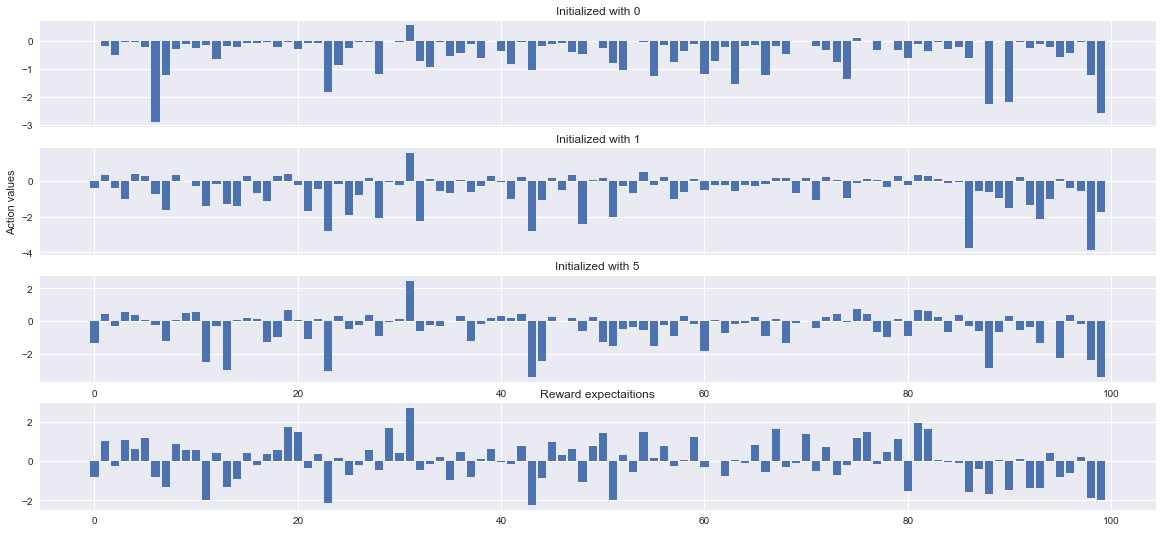

In [178]:
plt.figure(figsize=(20, 9))

a = plt.subplot('411')
plt.title('Initialized with 0')
plt.setp(a.get_xticklabels(), visible=False)
plt.bar(np.arange(BANDIT_COUNT), init_zeros[2])

b = plt.subplot('412', sharex=a)
plt.title('Initialized with 1')
plt.ylabel('Action values')
plt.setp(b.get_xticklabels(), visible=False)
plt.bar(np.arange(BANDIT_COUNT), init_ones[2])

plt.subplot('413', sharex=a)
plt.title('Initialized with 5')
plt.xlabel('Action num')
plt.bar(np.arange(BANDIT_COUNT), init_five[2])

plt.subplot('414')
plt.title('Reward expectaitions')
plt.bar(np.arange(BANDIT_COUNT), reward_expectations)

plt.show()

#### Remark

Setting initial values is a bit unfair in this problem, because we know all the distributions (the fact that all the distributions hvae small deviations), so for the purpose of more fair comparison of methods we will use `np.zeros()` as initial values for all methods.

#### $\varepsilon$-greedy policy
The previous approach only exploits the environment. However, agent should spend some time learning probability distribtion of rewards, to maximize its reward in the long term. Thus is a question of balance **exploration** and **exploitation**.

Possible improvement:
$$\pi_t(a)=\frac{1-\varepsilon}{|\mathcal{A}_t|}[a \in A_t] + \frac{\varepsilon}{|\mathcal{A}|},\ \varepsilon \in [0, 1].$$

#### Exercises
1. Implement this policy.
2. What happens if you increase $\varepsilon$?
3. How do you change $\varepsilon$ during agent learning?
4. Check this policy on model problem, using different $\varepsilon$.

In [205]:
def epsilon_greedy(eps):
    action_value = np.zeros(BANDIT_COUNT)
    action_count = np.zeros(BANDIT_COUNT)   # c(a) = 0
    reward_history = np.zeros(STEP_COUNT)   # store reward at each step
    reward_accumulated = np.zeros(STEP_COUNT)

    for t in range(STEP_COUNT):
        # choose action eps greedy
        if np.random.uniform() < eps:
            action = np.random.choice(range(BANDIT_COUNT))
        else:
            action = np.random.choice(np.flatnonzero(action_value == np.max(action_value)))

        reward = get_reward(action, reward_expectations)
        
        # update reward estimations
        if action_count[action]:
            action_value[action] += (reward - action_value[action]) / action_count[action]
        else:
            action_value[action] = reward
            
        # update stats
        action_count[action] += 1
        reward_history[t] = reward
        reward_accumulated[t] = reward_accumulated[t - 1] + reward
        
    return reward_history, reward_accumulated, action_value

#### Evaluation:

Now lets test this agent with $\varepsilon \in \{0.01, 0.1, 0.3, 0.5\}$

In [206]:
eps = [0.01, 0.1, 0.3, 0.5]
results = []

for e in eps:
    ret = eval_agent(epsilon_greedy, eps=e)
    results.append(ret)

100%|██████████| 100/100 [00:03<00:00, 28.17it/s]


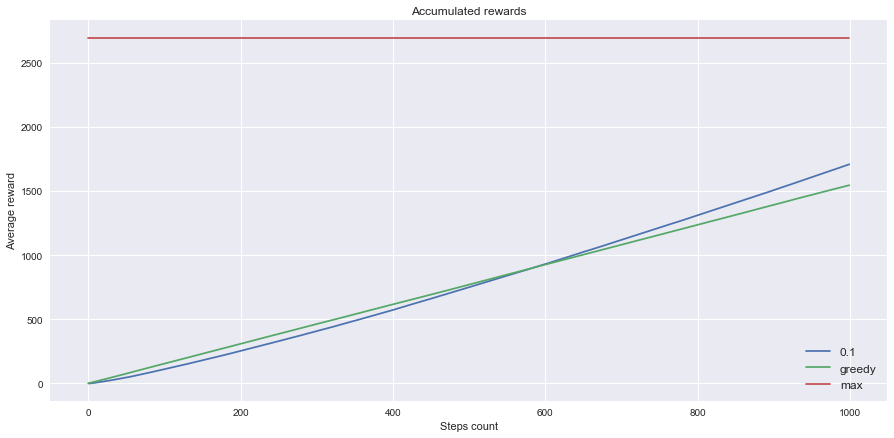

In [211]:
plt.figure(figsize=(15, 7))

plt.title('Accumulated rewards')
plt.xlabel('Steps count')
plt.ylabel('Average reward')

plt.plot(results[1][1], label='0.1')
plt.plot(init_zeros[1], label='greedy')
plt.plot([MAX_FINAL_REWARD] * STEP_COUNT, label='max')

plt.legend(fontsize='large')
plt.show()

#### Softmax
One more interpretation of $\varepsilon$-greedy policy

$$\pi_t(a)=\frac{\exp(\frac{1}{\varepsilon} \cdot Q_t(a))}{\sum_{b} \exp(\frac{1}{\varepsilon} \cdot Q_t(b))},\ \varepsilon >0.$$

#### Exercises
1. Implement this policy.
2. What happens if $\varepsilon \rightarrow 0$? What about $\varepsilon \rightarrow \infty$?
3. Compare softmax and $\varepsilon$-greedy policy on model problem.

In [215]:
def softmax_agent(eps):
    action_value = np.zeros(BANDIT_COUNT)
    action_count = np.zeros(BANDIT_COUNT)   # c(a) = 0
    reward_history = np.zeros(STEP_COUNT)   # store reward at each step
    reward_accumulated = np.zeros(STEP_COUNT)

    for t in range(STEP_COUNT):
        # choose action eps greedy
        probabilities = np.exp(action_value / eps)
        probabilities /= np.sum(probabilities)
        action = np.random.choice(range(BANDIT_COUNT), p=probabilities)

        reward = get_reward(action, reward_expectations)
        
        # update reward estimations
        if action_count[action]:
            action_value[action] += (reward - action_value[action]) / action_count[action]
        else:
            action_value[action] = reward
            
        # update stats
        action_count[action] += 1
        reward_history[t] = reward
        reward_accumulated[t] = reward_accumulated[t - 1] + reward
        
    return reward_history, reward_accumulated, action_value

#### Evaluating

Now let's see how softmax agent performs with different $\varepsilon$

100%|██████████| 100/100 [00:07<00:00, 12.64it/s]


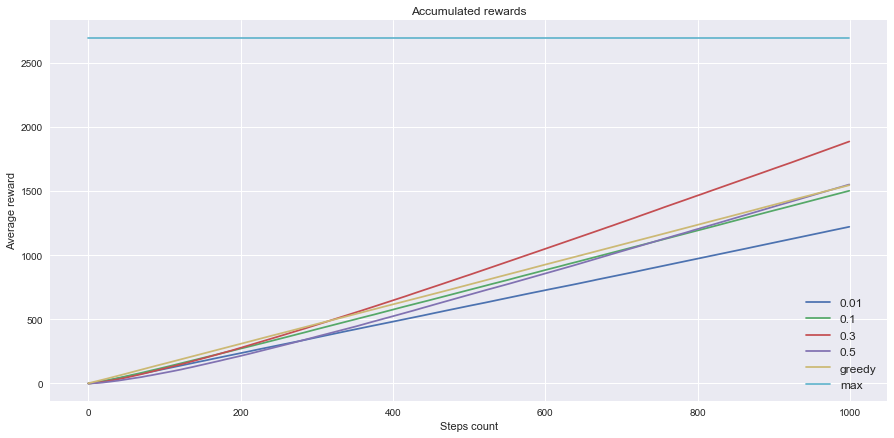

In [216]:
eps = [0.01, 0.1, 0.3, 0.5]
results = []

for e in eps:
    ret = eval_agent(softmax_agent, eps=e)
    results.append(ret)
    
plt.figure(figsize=(15, 7))

plt.title('Accumulated rewards')
plt.xlabel('Steps count')
plt.ylabel('Average reward')

plt.plot(results[0][1], label='0.01')
plt.plot(results[1][1], label='0.1')
plt.plot(results[2][1], label='0.3')
plt.plot(results[3][1], label='0.5')
plt.plot(init_zeros[1], label='greedy')
plt.plot([MAX_FINAL_REWARD] * STEP_COUNT, label='max')

plt.legend(fontsize='large')
plt.show()

#### UCB (upper confidence bound)
For each moment $t$ agent defines the most potentially profitable actions. Agent choice of $a \in A_t$ in accordance with following rule
$$\mathcal{A}_t = \arg\max Q_t(a) + \varepsilon \sqrt{\frac{2 \ln t}{c_t(a)}},\ \varepsilon \geq 0$$

The first part is well known, but the second summand is measure of how accurate agent estimates $Q_t(a)$ at this moment. The policy itself balances between exploration and exploitation. This policy can be considired as optimal in some sense, more inforamtion [here](http://homes.di.unimi.it/~cesabian/Pubblicazioni/ml-02.pdf).

#### Exercises
1. Implement policy.
2. What happens if $\varepsilon \rightarrow 0$? What about $\varepsilon \rightarrow \infty$?
3. Compare this policy with softmax and $\varepsilon$-greedy policy.

In [218]:
def UCB_agent(eps):
    action_value = np.zeros(BANDIT_COUNT)
    action_count = np.zeros(BANDIT_COUNT)   # c(a) = 0
    reward_history = np.zeros(STEP_COUNT)   # store reward at each step
    reward_accumulated = np.zeros(STEP_COUNT)

    for t in range(1, STEP_COUNT + 1):
        # choose action eps greedy
        if 0 in action_count:
            action = np.random.choice(np.flatnonzero(action_count == 0))
        else:
            ucb_values = action_value + eps * np.sqrt(2 * np.log(t) / action_count)
            action = np.random.choice(np.flatnonzero(ucb_values == np.max(ucb_values)))

        reward = get_reward(action, reward_expectations)
        
        # update reward estimations
        if action_count[action]:
            action_value[action] += (reward - action_value[action]) / action_count[action]
        else:
            action_value[action] = reward
            
        # update stats
        action_count[action] += 1
        reward_history[t - 1] = reward
        reward_accumulated[t - 1] = reward_accumulated[t - 2] + reward
        
    return reward_history, reward_accumulated, action_value

#### Evaluation

100%|██████████| 100/100 [00:04<00:00, 22.87it/s]


NameError: name 'init_fives' is not defined

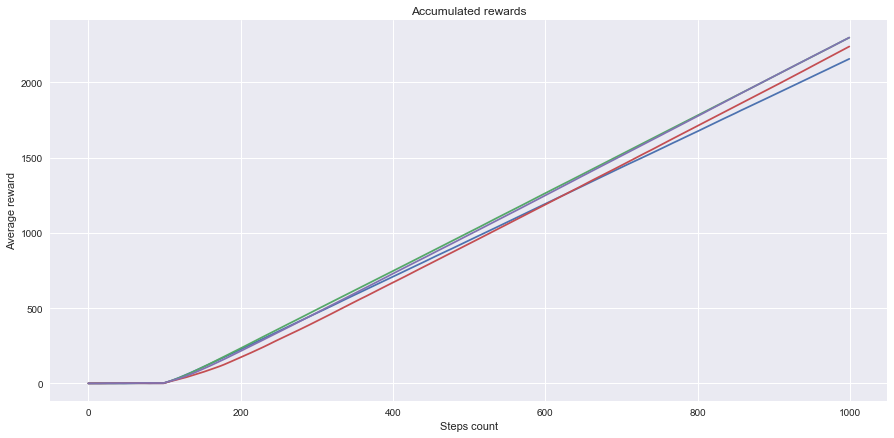

In [224]:
eps = [0.01, 0.2, 1/np.sqrt(2), 0.5]
results = []

for e in eps:
    ret = eval_agent(UCB_agent, eps=e)
    results.append(ret)
    
plt.figure(figsize=(15, 7))

plt.title('Accumulated rewards')
plt.xlabel('Steps count')
plt.ylabel('Average reward')

plt.plot(results[0][1], label='0.01')
plt.plot(results[1][1], label='0.1')
plt.plot(results[2][1], label='0.3')
plt.plot(results[3][1], label='0.5')
plt.plot(init_fives[1], label='greedy')
plt.plot([MAX_FINAL_REWARD] * STEP_COUNT, label='max')

plt.legend(fontsize='large')
plt.show()

#### Gradient policy
There are also adaptive policy. They can be used, if the environment is not stationary (the distribution of rewards may slowly change). In this case, it is proposed to use the already familiar exponential smoothing
We find smoothed average reward at moment $t$ for all actions:
$$\bar{r}_{t+1} = (1-\alpha_t)\cdot\bar{r}_t(a)+\alpha_t r_{t+1} = \bar{r}_t +\alpha_t (r_{t+1}-\bar{r}_t(a)),\ \alpha_t \in [0, 1].$$

**Hint** Сonvergence condition
* $\sum^{\infty} \alpha_t = \infty$
* $\sum^{\infty} \alpha^2_t < \infty$

By the way, if $\alpha_t = \frac{1}{t}$, then $\bar{r}_{t+1}$ is just average of all $r_t$.

For each action we have some priority $p_t(a)$. After each step we make following update
$$p_{t+1}(a) = p_t(a)+\lambda(r_t-\bar{r}_t)(1-\pi_t(a)), \text{ $a$ is choosen,}$$

$$p_{t+1}(a) = p_t(a)-\lambda(r_t-\bar{r}_t)\pi_t(a), \text{ another case.}$$

So policy $\pi_{t+1}$ looks like:
$$\pi_{t+1}(a) = \frac{\exp(p_{t+1}(a))}{\sum_{b} \exp(p_{t+1}(b))}$$
More details about this method you can find in the book.

#### Exercise
1. Implement policy.
2. In conclusion, try to understand which model is better for our problem.

In [232]:
def gradient_agent(lmd):
    action_score = np.zeros(BANDIT_COUNT)
    reward_estimate = 0
    reward_history = np.zeros(STEP_COUNT)   # store reward at each step
    reward_accumulated = np.zeros(STEP_COUNT)

    for t in range(STEP_COUNT):
        # choose action eps greedy
        probabilities = np.exp(action_score)
        probabilities /= np.sum(probabilities)
        action = np.random.choice(range(BANDIT_COUNT), p=probabilities)

        reward = get_reward(action, reward_expectations)

        if reward_estimate == 0:
            reward_estimate = reward
        else:
            reward_estimate += (reward - reward_estimate) / (t + 1)

        cur_action_score = action_score[action] + lmd * (reward - reward_estimate) * (1 - probabilities[action])
        action_score = action_score - lmd * (reward - reward_estimate) * probabilities
        action_score[action] = cur_action_score
        
        # update stats
        reward_history[t] = reward
        reward_accumulated[t] = reward_accumulated[t - 1] + reward
        
    return reward_history, reward_accumulated, action_score

100%|██████████| 100/100 [00:07<00:00, 13.34it/s]


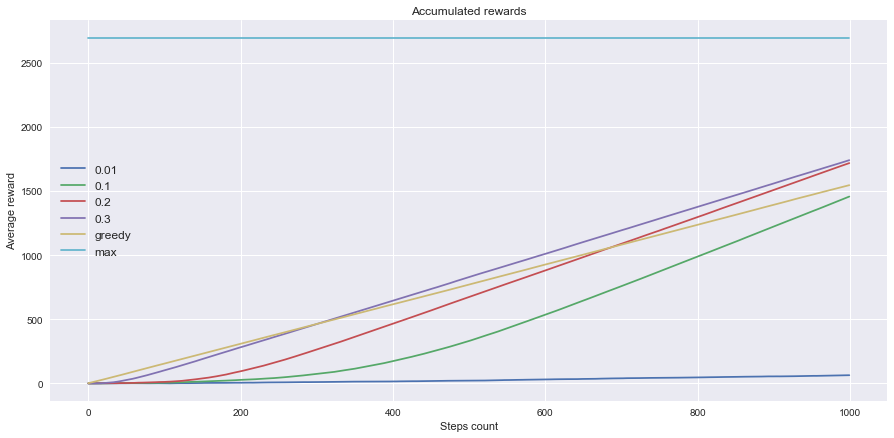

In [234]:
eps = [0.01, 0.1, 0.2, 0.6]
results = []

for e in eps:
    ret = eval_agent(gradient_agent, lmd=e)
    results.append(ret)
    
plt.figure(figsize=(15, 7))

plt.title('Accumulated rewards')
plt.xlabel('Steps count')
plt.ylabel('Average reward')

plt.plot(results[0][1], label='0.01')
plt.plot(results[1][1], label='0.1')
plt.plot(results[2][1], label='0.2')
plt.plot(results[3][1], label='0.3')
plt.plot(init_zeros[1], label='greedy')
plt.plot([MAX_FINAL_REWARD] * STEP_COUNT, label='max')

plt.legend(fontsize='large')
plt.show()

### 2. Markov decison process
#### Problem statement
Now agent acts in some environment with finite set of states $\mathcal{S}$. At moment $t$ agent at state $s_t$ can choose action $a_t \in \mathcal{A}_{s_t} \subset \mathcal{A}$. After agent's action, environment moves it to state $s_{t+1}$ and give reward $r_{t+1}$. Environment behaviour is defined with
$$p(s_{t+1}, r_{t+1}|s_t, a_t)  = \Pr\{ S_{t+1} = s_{t+1}, R_{t+1} =  r_{t+1} | S_t = s_t, A_t = a_t\}.$$

Agent has some policy $\pi$, which at moment $t$ defines probabilty of action $a_t \in \mathcal{A}_{s_t}$ for state $s_t$ $\pi_t(a_t|s_t) = p(a_t|s_t)$. Informally agent needs to maximize the total reward. If the decision process is finite, the problem is formalized as maximizing
$$G = \sum_{t=0}^{T} R_{t+1},$$
here $T$ – moment of time, when agent achives final state. We will consider this value as a random. If the process can last very long or infinite time than we have dealing with a discounted reward
$$ G_t = \sum_{k=0}^{\infty} \gamma^{k} R_{t+k+1},$$
here $\gamma \in [0, 1]$ defines how deep we look into the future.

The probability that the process moves into its new state is influenced by the chosen action. Specifically, it is given by the state transition function. Thus, the next state  depends on the current state and the decision maker's action. But given state and action, it is conditionally independent of all previous states and actions, in other words, the state transitions of an MDP satisfies the Markov property.

#### Exercises
1. Give life example of Markov decision process (it may be any game, etc.).
2. Can you give an example where a decision can't be modeled with a Markov process?
3. Using $p(s_{t+1}, r_{t+1}|s_t, a_t)$, find values below (all distribution are discrete):
  * $r(s_{t}, a_{t}) = \mathbb{E}[R_{t+1}|S_t = s_t, A_t = a_t]$ – average reward for action $a_t$ in state $s_t$ 
  * $p(s_{t+1} | s_t, a_t) = \Pr\{S_{t+1} = s_{t+1} | S_t = s_t, A_t = a_t \}$ – probability to move from $s_t$ to $s_{t+1}$, making $a_t$.
  * $r(s_t, a_t, s_{t+1}) = \mathbb{E}[R_{t+1}|S_{t+1} = s_{t+1}, S_t = s_t, A_t = a_t]$ – average reward when moving from $s_t$ to $s_{t+1}$, making $a_t$.

### Example of MDP

We can model PACMAN game as Markov decision process. The state will be actual information about the game at the moment (might by position's of enemies + your position, or screenshot, or series of screenshots). The actions would be to turn or go forward. Reward can be score if we are alive and some negative number if we died. This decision process is MDP because it satisfies Markov property. Indeed previous states do not affect transition to the next state. Note: agent does not know the probability $p(s_{t+1}| s_t, a_t)$

### Can't model with MDP

We can't model chess with MDP if we use board configuration as state because we have special situations like [this](https://en.wikipedia.org/wiki/Castling), which depend on history of the game and thus this descision process doesn't satisfy Markov property.

### Part 3

  * $r(s_{t}, a_{t}) = \sum_{s, r} r \cdot p(s, r | s_t, a_t)$
  * $p(s_{t+1} | s_t, a_t) = \sum_r p(s_{t+1}, r | s_t, a_t)$
  * $r(s_t, a_t, s_{t+1}) = \sum_r r \cdot p(s_{t+1}, r | s_t, a_t)$

#### Main definitions 
State-value function under the strategy of $\pi$ returns for state $s$ total reward, that agent gets, starting from $s$
$$V^\pi(s) = \mathbb{E}[G_t|S_t=s] = \mathbb{E}\Big[\sum_{k=0}^{\infty} \gamma^{k+1}R_{t+k+1}|S_t=s\Big].$$

Action-value function under the strategy $\pi$ for action $a$ and state $s$ returns total reward that agent gets, starting from $s$ and making $a$
$$Q^\pi(s, a) = \mathbb{E}[G_t|S_t=s, A_t=a] = \mathbb{E}\Big[\sum_{k=0}^{\infty} \gamma^{k+1}R_{t+k+1}|S_t=s,  A_t=a\Big].$$

Thus we have following equations (the first two are Bellman equations):

$$V^{\pi}(s) = \mathbb{E}\big[R_{t+1} + \gamma V^{\pi}(S_{t+1}) | S_t=s\big]$$

$$Q^{\pi}(s, a) = \mathbb{E}\big[R_{t+1} + \gamma Q^{\pi}(S_{t+1}, A_{t+1}) | S_t=s, A_t=a\big]$$

$$Q^{\pi}(s, a) = \mathbb{E}\big[R_{t+1} + \gamma V^{\pi}(S_{t+1}) | S_t=s, A_t=a\big]$$

#### Remark
It is important to note that policy $\pi$ is fixed and doesn't change with time. Although in real practice it is not true, because our strategy is constantly updating when agent learns environment.
Policy $\pi^{*}$ is optimal, if for each state $s$ and any other policy $\pi$ it is true that $V_{\pi^{*}}(s) \geq V_{\pi}(s)$. Posibly, there are several different optimal policies, however functions $V(s)$ and $Q(s, a)$, which they defines are the same. So, we denote these functions $V^*(s)$ и $Q^*(s, a)$ as optimal.

Equations below are Bellman optimality equations (more info [here](https://en.wikipedia.org/wiki/Bellman_equation)):
$$V^*(s) = \max_{a \in \mathcal{A}} \mathbb{E}\big[R_{t+1} + \gamma V^*(S_{t+1}) | S_t=s, A_t=a\big]$$
$$Q^*(s, a) = \mathbb{E}\big[R_{t+1} + \gamma \max_{b \in \mathcal{A}} Q^*(S_{t+1}, b) | S_t=s, A_t=a\big]$$

Then the following two greedy strategies are equivalent and optimal ($\mathcal{A}_t$ – set):
$$\mathcal{A}_t = \arg\max_{a \in \mathcal{A}} \mathbb{E}\big[R_{t+1} + \gamma V^*(s_{t+1}) | s_t, a \big]$$
$$\mathcal{A}_t = \arg\max_{a \in \mathcal{A}} Q^*(s_t, a)$$

#### Dynamic programming
This part is based on the fact, that $p(s',r|s,a)$ is known.

#### Iterative policy evaluation
Let agent has some fixed policy $\pi$, then for $V^{\pi}$ we have
$$V^{\pi}(s) = \sum_a \pi(a|s) \sum_{s',r} p(s',r|s,a) \big[r + \gamma V^{\pi}(s') \big]$$

For simplicity we assume that the distribution of rewards is discrete random variable. Otherwise, it is necessary to use operator of integration instead of sum. For each state $s$ we can can evaluate $V^{\pi}$, using iterative algorithm ($V_0$ is initialized randomly)
$$V_{n+1}(s) = \sum_a \pi(a|s) \sum_{s',r} p(s',r|s,a) \big[r + \gamma V_n(s') \big].$$

By the way, if $s$ is a final state, then $V(s)$ is already known and we may use this value as initialization for faster convergence. The computation stops when $V(s)$ varies negligible from iteration to iteration.

#### Remarks
1. We make assumption that $p(s',r|s,a)$ is known, but it's often not truth in practice.
2. Compution of $V_{n+1}$ can be done **in place**, it accelerates convergence, since in the process of computation we will use the values from iteration $n$ and some new values from iteration $n+1$.

#### Policy improvement theorem
Suppose there are policies $\pi$ and $\pi'$, and for each state $s$ we have
$$Q^{\pi}(s, \pi'(s)) \geq V^{\pi}(s),$$
then the following inequality holds
$$V^{\pi'}(s) \geq V^{\pi}(s).$$

The main interest of this theorem is that it allows us to improve the current policy. We know how to calculate $V^{\pi}(s)$, so

$$
Q^{\pi}(s, a) =
\mathbb{E}\big[R_{t+1} + \gamma V^{\pi}(S_{t+1}) | S_t=s, A_t=a\big] =
\sum_{s',r}p(s',r|s, a)\big[ r + \gamma V^{\pi}(s') \big]
$$

In this way we can improve our policy
$$\pi'(a) = \arg\max_a Q^{\pi}(s, a).$$
The writing above means, that policy chooses action uniformly among all optimal actions. If we can't improve $V^{\pi}$, then out state-value function is optimal and satisfies the equation the Bellman equation. So, policy, which defines this policy, is also optimal.

#### Policy interation
Performing alternately calculation of $V^{\pi}$ and improving $\pi$, we can find optimal policy $\pi^*$. It should be noted that as initialization values of $V(s)$ you may use state-value function from previous iteration, it helps significantly speeds up the convergence of the algorithm.

#### Value interation
There is also interesting approach to compute $V^{*}(s)$ of optimal strategy $\pi^{*}$
$$V_{n+1}(s) = \max_a \sum_{s',r} p(s',r|s,a) \big[r + \gamma V_n(s') \big].$$

You may understand this method in the following way. On the one hand we in greedy manner update state value function during each iteration of value function evaluation. On the other hand we use Bellman equation to evaluate $V^{*}$ iteratively. It's rather practical method.

#### Exercises
1. Let you environment have 100 states. The distribution function $p(s',r|s,a)$ may be defined by your own.
2. Fix some discount value and find optimal policy.
3. What method is faster? For any state $s$, check how $V^*(s)$ varies during $\gamma$ changing.
4. Plot $\gamma \times V^*(s)$ for some 5 states.

### Creating enviroment and agent

Let's create enviroment by defining state transition matrix and reward matrix (we consider all rewards to be fixed for `[action, state -> state']`).

In [234]:
# TODO
STATE_COUNT = 100
ACTION_COUNT = 70

def init_environment():
    # P -- state transition matrix
    # R -- reward matrix
    P = np.zeros((ACTION_COUNT, STATE_COUNT, STATE_COUNT))
    R = np.zeros((ACTION_COUNT, STATE_COUNT, STATE_COUNT))
    
    # now fill transition matrix with random probabilities
    np.random.seed(42)
    for a in range(ACTION_COUNT):
        for s in range(STATE_COUNT):
            # choose states to which agent can be thrown 
            # from state `s` doing action `a`.
            # there would be >= 0.4 * STATE_COUNT such states
            chosen_states = np.random.uniform(0, 1, STATE_COUNT)
            threshold = np.random.uniform(0.6, 0.9)

            chosen_states[chosen_states >= threshold] = 1.0
            chosen_states[chosen_states <= threshold] = 0.0
            if np.max(chosen_states) == 0.0:
                chosen_states[np.random.choice(range(STATE_COUNT))] = 1

            # set prob of transition
            P[a, s, :] = np.random.uniform(0, 20, STATE_COUNT) * chosen_states
            P[a, s, :] /= np.sum(P[a, s, :])
            
            # set rewards for different tranzitions
            trans_ind = np.flatnonzero(chosen_states != 0)
            R[a, s, trans_ind] = np.random.normal(loc=0, scale=600, size=len(trans_ind))
            
    return P, R

Next function creates agent with equiprobable actions and random state value function.

In [235]:
def init_agent(P, R):
    """
        returns:
            policy = np.array(size=[action, state]) -- initial policy
            V = np.array(size=[state,]) -- initial state value function
    """
    # initial policy chooses actions with equal probabilities
    policy = np.ones((ACTION_COUNT, STATE_COUNT)) / ACTION_COUNT
    np.random.seed(42)
    V = np.random.normal(loc=0, scale=2, size=STATE_COUNT)
    return policy, V    

In [236]:
P, R = init_environment()     # generate enviroment
policy, V = init_agent(P, R)  # initialize agent

### Аuxiliary functions

Next function finds state value function for given policy

In [237]:
def policy_evaluation(P, R, V, policy, discount=.3, eps=1e-6, verbose=False):
    """
    Apply iterative policy evaluation algorithm to find approximate 
    state value function for `policy` in MDP given by transition and
    reward matrices. 
    
    All parameters should be initialized
    
    params:
        P = np.array(size=[actions, states, states'])  
        R = np.array(size=[actions, states, states'])
        V = np.array(size=[states])
        policy = np.array([action, state]) 
        
    returns:
        V = np.array(size=(states,)) -- approximate state value function
    """
    def get_expected_value(state):
        expected_return = P[:, state, :] * (R[:, state, :] + discount * V)
        return np.sum(expected_return, axis=1)
                
    
    dV = 0
    i = 1
    improved = True
    while improved:
        prev_V = np.copy(V)
        for state in range(STATE_COUNT):
            V[state] = np.sum(policy[:, state] * get_expected_value(state))
        dV = np.abs(prev_V - V).max()
        if dV < eps:
            improved = False
        if verbose and i % 100 == 0:
            print('Finished iteration %d. Current dV=%f' % (i, dV))
        i += 1
    return V

`policy_improvement` function tries to improve current policy given it's state value function.

In [238]:
def policy_improvement(P, R, V, policy, discount):
    """
    One step of policy improvement. Given MDP value function and policy 
    returns updated policy and boolean value, which tells if this policy
    is optimal
    
    returns:
        bool optimal
        ndarray policy
    """
    def get_expected_return(state):
        expected_return = P[:, state, :] * (R[:, state, :] + discount * V)
        return np.sum(expected_return, axis=1)

    is_optimal = True

    for state in range(STATE_COUNT):
        # find actions whic maximaze return from state s
        expected_return = get_expected_return(state)
        best_actions = np.flatnonzero(expected_return == np.max(expected_return))
        
        # updating policy
        old_policy = np.copy(policy[:, state])
        policy[:, state] = 0
        policy[best_actions, state] = 1.0 / len(best_actions)
        
        if np.any(policy[:, state] != old_policy):
            is_optimal = False

    return is_optimal, policy

### Implementing policy iteration

In [239]:
def policy_iteration(P, R, discount, eps=1e-6, verbose=False):
    """
    TODO comments
    """
    # Initialize agent
    policy, V = init_agent(P, R)
    
    optimal = False
    i = 1
    while not optimal:
        V = policy_evaluation(P, R, V, policy, discount, eps)
        optimal, policy = policy_improvement(P, R, V, policy, discount)
        if verbose and i % 100 == 0:
            print('Iteration %d' % i)
        i += 1
    if verbose:
        print('Found optimal policy in %d iterations' % i)
    return policy

Now let's how policy iteration method works: 

In [240]:
#%%timeit
P, R = init_environment()     # generate enviroment
pi_policy = policy_iteration(P, R, discount=.9, eps=1e-12, verbose=False)

### Implementing value iteration

In [241]:
def value_iteration(P, R, discount, eps=1e-6, verbose=False):

    def get_expected_return(state):
        expected_return = P[:, state, :] * (R[:, state, :] + discount * V)
        return np.sum(expected_return, axis=1)
    
    # Initialize agent
    _, V = init_agent(P, R)
    
    # iteratively update state value function
    dV = 0
    optimal = False
    i = 1
    while not optimal:
        prev_V = np.copy(V)
        for state in range(STATE_COUNT):
            V[state] = np.max(get_expected_return(state))
        dV = np.abs(prev_V - V).max()
        if dV < eps:
            optimal = True
        if verbose and i % 1000 == 0:
            print('Iteration %d' % i)
    
    # find determenistic policy given the state value function
    policy = np.zeros((ACTION_COUNT, STATE_COUNT))
    for state in range(STATE_COUNT):
        expected_return = get_expected_return(state)
        best_actions = np.flatnonzero(expected_return == np.max(expected_return))
        
        # updating policy
        policy[best_actions, state] = 1.0 / len(best_actions)
    return policy, V

Now let's see how value iteration performs and then compare resulting policies and make sure they are the same.

In [242]:
#%%timeit
P, R = init_environment()     # generate enviroment
vi_policy, V = value_iteration(P, R, discount=.9, eps=1e-12)

In [243]:
print(np.all(vi_policy == pi_policy))

True


As we can see both policies converged to the same policy. But value iteration converges significantly faster. Now let's use value iteration method to build plots.

In [231]:
def get_graph(state=None):
    if state is None:
        np.random.seed(102313)
        state = np.random.randint(0, STATE_COUNT)
    discounts = np.linspace(.0, .99, num=100)
    state_values = []
    for discount in tqdm(discounts):
        _, V = value_iteration(P, R, discount=discount, eps=1e-12)
        state_values.append(V[state])
    return (discounts, np.copy(state_values))

100%|██████████| 100/100 [00:43<00:00,  2.31it/s]


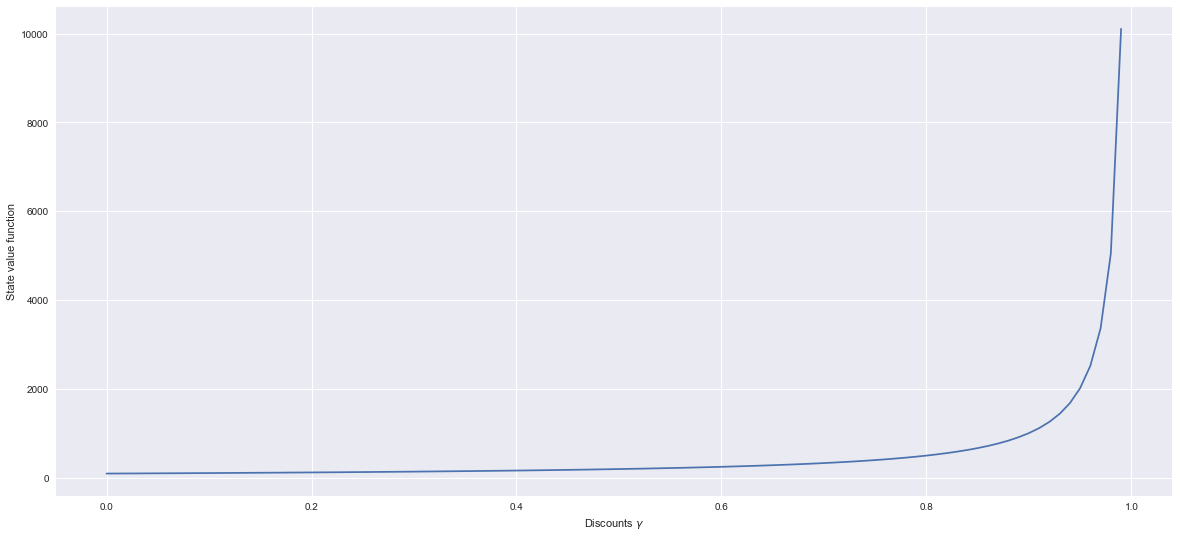

For state 67


In [232]:
plt.figure(figsize=(20, 9))
plt.xlabel(r'Discounts $\gamma$')
plt.ylabel('State value function')
plt.plot(*get_graph())
plt.show()
print('For state', state)

As we can see value are increasing when $\gamma \to 1$, the value of states increases (and in fact goes to $\infty$) becaues "we look further into the future" and encounter delayed rewards). When $\gamma = 1$ program freezes probably because this MDP does not have clearly defined terminal state and there might be positive reward loop.

100%|██████████| 100/100 [00:48<00:00,  2.08it/s]


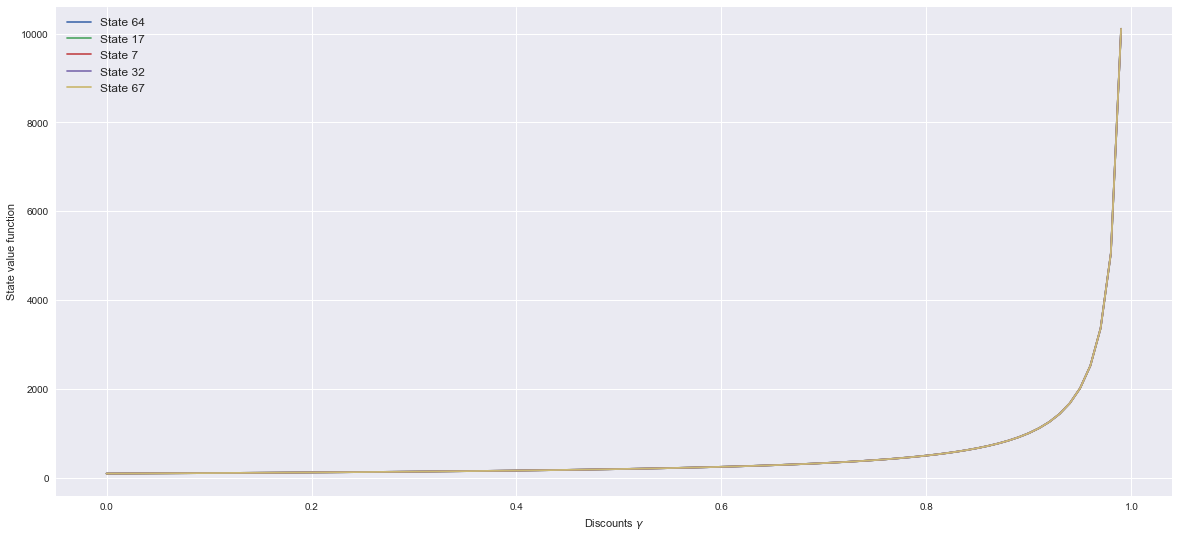

In [233]:
np.random.seed(12311111)
states = np.random.choice(range(STATE_COUNT), size=5)
graphs = []

for state in states:
    graphs.append(get_graph())
    
plt.figure(figsize=(20, 9))
plt.xlabel(r'Discounts $\gamma$')
plt.ylabel('State value function')

for i, graph in enumerate(graphs):
    plt.plot(*graph, label='State {}'.format(states[i]))

plt.legend(fontsize='large')
plt.show()

### 3. Model problem
As a model problem we choose tic-tac-toe game. One agent plays against another, so environament for each player is its opponent. The set of states $\mathcal{S}_{X}$ is all possible positions of tic-tac-toe game for Xs and the set $\mathcal{S}_{O}$ defined in the same way for Os. You need to train both agents during some series of games where they play with each other. The criterion of success – both agent don't lose human.

### 4. Temporal difference
The speech will focus on more practical methods. Let imagine that we evaluate $V^{\pi}(s)$ for our policy $\pi$. Our agent visited state $s_t$ and we know total reward $G_t$. When agent visites the state $s_t$, we can improve estimation of $V^{\pi}$ using exponential smoothing
$$V^{\pi}_{n+1}(s_t) = V_{n}^{\pi}(s_t) + \alpha \big(G_t - V_{n}^{\pi}(s_t)\big).$$

However, you can make some trick and rewrite $G_t$
$$V_{n+1}^{\pi}(s_t) = V_{n}^{\pi}(s_t) + \alpha \big(R_t + \gamma V^{\pi}(S_{t+1}) - V_{n}^{\pi}(s_t)\big),$$
so we can update $V^{\pi}(s_t)$ after each visiting $s_t$. Similarly, we can compute
$$Q_{n+1}(s_t, a_t) = Q_{n}(s_t, a_t) + \alpha \big(R_{t+1} + \gamma Q^{\pi}(S_{t+1}, A_{t+1}) - Q_{n}^{\pi}(s_t, a_t)\big).$$

#### SARSA (State-Action-Reward-State-Action)
So, we want to find optimal policy $\pi^{*}$. Let's suppose we have some initial approximation $Q(s, a)$. We use нее $\varepsilon$-greedy policy $\mathcal{A}_s = \arg\max_{a \in \mathcal{A}} Q(s, a)$. 

$$\pi(a|s)=\frac{1-\varepsilon}{|\mathcal{A}_s|}[a \in \mathcal{A}_s] + \frac{\varepsilon}{|\mathcal{A}|},\ \varepsilon \in [0, 1].$$

In accordance with policy $\pi$ we choose $a_t$ and get reward $R_{t+1}$, after that environment move agent to state $S_{t+1}$. Agent one more time choose action $A_{t+1} \sim \pi(a|S_{t+1})$ and doesn't act in the environemnt, but only update $Q$ function
$$Q(s_t, a_t) = Q(s_t, a_t) + \alpha \big(R_{t+1} + \gamma Q^{\pi}(S_{t+1}, A_{t+1}) - Q^{\pi}(s_t, a_t)\big).$$

Also, there is more variation of this idea, that uses expected Q-value.
$$Q(s_t, a_t) = Q(s_t, a_t) + \alpha \big(R_{t+1} + \gamma \sum_b \pi(b|S_{t+1}) Q^{\pi}(S_{t+1}, b) - Q^{\pi}(s_t, a_t)\big).$$
So we use $\varepsilon$-greedy approach to improve our policy and evaluate.

####  Q-learning
The idea of this method is rather similar, but we also greedy update action-value function $Q$ 
$$Q(s_t, a_t) = Q(s_t, a_t) + \alpha \big(R_{t+1} + \gamma \max_{b} Q(S_{t+1}, b) - Q(s_t, a_t)\big).$$ For choosing actions during learning agent can use any policy, e.g. $\varepsilon$-greedy or softmax policy.

#### Exercises
1. Implement both algorithm for our model problem.
2. Which one converges faster? How can you estimate it?
3. Compare how action-value function $Q(s_t, a_t)$ differs for these two methods.
4. Try to play with your agents...
5. Use intentionally losing strategy for Os. What happened?
6. Try to beat the agent for Xs.

In [1]:
print(' '*9, 'abs')

          abs


In [20]:
board_format = """
=============
| {} | {} | {} |
|---+---+---|
| {} | {} | {} |
|---+---+---|
| {} | {} | {} |
=============
"""

class Game():
    def __init__(self):
        self.board = ' ' * 9
        self.

    def drawBoard(self):
        num = 1
        print_board = []
        for c in self.board:
            if c == ' ':
                print_board.append(num)
                num += 1
            else:
                print_board.append(c)
        print(board_format.format(*print_board))


In [21]:
test = Game()
test.drawBoard()


| 1 | 2 | 3 |
|---+---+---|
| 4 | 5 | 6 |
|---+---+---|
| 7 | 8 | 9 |



In [24]:
if None or False:
    print('eee')

In [26]:
if 0:
    print('ss')

In [27]:
dict([(1, 'a'), (2, 'b')])

{1: 'a', 2: 'b'}

In [35]:
actions = [1, 3]
Q = {('a', 1): 100, ('b', 3): 500, ('b', 1): -10}
state = 'b'
actions_Q = dict(((state, a), Q[state, a]) for a in actions)

In [37]:
Q['sta'] = 0

In [39]:
import random

In [40]:
random.random?

In [41]:
Q['a', 1]

100